In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [5]:
! chmod 600  ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [6]:
! kaggle datasets download -d pinxau1000/radioml2018

Dataset URL: https://www.kaggle.com/datasets/pinxau1000/radioml2018
License(s): CC-BY-NC-SA-4.0
100% 18.0G/18.0G [03:39<00:00, 97.5MB/s]
100% 18.0G/18.0G [03:39<00:00, 88.0MB/s]


In [7]:
! unzip radioml2018.zip

Archive:  radioml2018.zip
  inflating: GOLD_XYZ_OSC.0001_1024.hdf5  
  inflating: LICENSE.TXT             
  inflating: classes-fixed.json      
  inflating: classes-fixed.txt       
  inflating: classes.txt             
  inflating: datasets.desktop        


1. Data Loading and Preprocessing

In [8]:
import numpy as np
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split

# Load the dataset
dataset_file = h5py.File("GOLD_XYZ_OSC.0001_1024.hdf5", "r")

# Base modulation classes
base_modulation_classes = [
    'OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK',
    '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM',
    '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC',
    'FM', 'GMSK', 'OQPSK'
]

# Selected modulation classes
selected_modulation_classes = ['4ASK', 'BPSK', 'QPSK', '16PSK', '16QAM', 'FM', 'AM-DSB-WC', '32APSK']
selected_classes_id = [base_modulation_classes.index(cls) for cls in selected_modulation_classes]

# Number of SNR values to include (high SNR)
N_SNR = 4  # From 22 dB to 30 dB

# Initialize data arrays
X_data = None
y_data = None

# Extract data for selected modulations and SNRs
for id in selected_classes_id:
    # Calculate start and end indices for the selected SNR range
    start_idx = 106496 * (id + 1) - 4096 * N_SNR
    end_idx = 106496 * (id + 1)

    X_slice = dataset_file['X'][start_idx:end_idx]
    y_slice = dataset_file['Y'][start_idx:end_idx]

    # Concatenate data
    if X_data is not None:
        X_data = np.concatenate([X_data, X_slice], axis=0)
        y_data = np.concatenate([y_data, y_slice], axis=0)
    else:
        X_data = X_slice
        y_data = y_slice

# Reshape X_data to (samples, 32, 32, 2)
X_data = X_data.reshape(len(X_data), 32, 32, 2)

# Prepare labels
y_data_df = pd.DataFrame(y_data)

# Remove columns with all zeros (unused modulation classes)
for column in y_data_df.columns:
    if y_data_df[column].sum() == 0:
        y_data_df = y_data_df.drop(columns=[column])

# Set column names to selected modulation classes
y_data_df.columns = selected_modulation_classes

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data_df, test_size=0.2, random_state=42, stratify=y_data_df.values.argmax(axis=1)
)



2. Model Definition

In [9]:
import keras
import tensorflow.keras as tk
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

def create_model():
    learning_rate = 0.0001
    i_input = keras.layers.Input(shape=(32, 32, 1), name='i_input')
    q_input = keras.layers.Input(shape=(32, 32, 1), name='q_input')

    # Q-path CNN
    cnn_q = tk.layers.Conv2D(64, 3, activation=LeakyReLU(alpha=0.1))(q_input)
    cnn_q = tk.layers.Conv2D(64, 3, activation=LeakyReLU(alpha=0.1))(cnn_q)
    pool_q = tk.layers.MaxPool2D(pool_size=3, strides=2, padding='valid')(cnn_q)
    cnn_q = tk.layers.Conv2D(128, 3, activation=LeakyReLU(alpha=0.1))(pool_q)
    cnn_q = tk.layers.Conv2D(128, 3, activation=LeakyReLU(alpha=0.1))(cnn_q)
    pool_q = tk.layers.MaxPool2D(pool_size=3, strides=2, padding='valid')(cnn_q)
    flatten_q = tk.layers.Flatten()(pool_q)

    # I-path CNN
    cnn_i = tk.layers.Conv2D(64, 3, activation=LeakyReLU(alpha=0.1))(i_input)
    cnn_i = tk.layers.Conv2D(64, 3, activation=LeakyReLU(alpha=0.1))(cnn_i)
    pool_i = tk.layers.MaxPool2D(pool_size=3, strides=2, padding='valid')(cnn_i)
    cnn_i = tk.layers.Conv2D(128, 3, activation=LeakyReLU(alpha=0.1))(pool_i)
    cnn_i = tk.layers.Conv2D(128, 3, activation=LeakyReLU(alpha=0.1))(cnn_i)
    pool_i = tk.layers.MaxPool2D(pool_size=3, strides=2, padding='valid')(cnn_i)
    flatten_i = tk.layers.Flatten()(pool_i)

    # Concatenate I and Q paths
    concat = keras.layers.concatenate([flatten_q, flatten_i])

    # Reshape and LSTM layer
    reshape = keras.layers.Reshape((1, -1))(concat)
    lstm = tk.layers.LSTM(256, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)(reshape)

    # Dense layers with dropout
    dense = keras.layers.Dense(1024, activation=LeakyReLU(alpha=0.1))(lstm)
    dropout = tk.layers.Dropout(0.5)(dense)
    dense = keras.layers.Dense(1024, activation=LeakyReLU(alpha=0.1))(dropout)
    dropout = tk.layers.Dropout(0.5)(dense)
    dense = keras.layers.Dense(1024, activation=LeakyReLU(alpha=0.1))(dropout)
    dropout = tk.layers.Dropout(0.5)(dense)
    dense = keras.layers.Dense(256, activation=LeakyReLU(alpha=0.1))(dropout)
    dropout = tk.layers.Dropout(0.5)(dense)
    dense = keras.layers.Dense(32, activation=LeakyReLU(alpha=0.1))(dropout)

    # Output layer
    outputs = keras.layers.Dense(len(selected_modulation_classes), activation='softmax')(dense)

    # Compile the model
    model = keras.Model(inputs=[i_input, q_input], outputs=outputs)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ q_input (InputLayer)      │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ i_input (InputLayer)      │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 30, 30, 64)     │            640 │ q_input[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 30, 30, 64)     │            640 │ i_input[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 28, 28, 64)     │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 28, 28, 64)     │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 13, 13, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 13, 13, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 11, 11, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 11, 11, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 9, 9, 128)      │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 9, 9, 128)      │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 4, 4, 128)      │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 4, 4, 128)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2048)           │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 2048)           │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 4096)           │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├──────────────────────

 Total params: 7,608,744 (29.03 MB)

 Trainable params: 7,608,744 (29.03 MB)

 Non-trainable params: 0 (0.00 B)

3. Model Training

In [10]:
batch_size = 64
epochs = 25

path_checkpoint = "model_checkpoint.weights.h5"
es_callback = tk.callbacks.EarlyStopping(monitor="accuracy", min_delta=0, patience=10)

modelckpt_callback = tk.callbacks.ModelCheckpoint(
    monitor="accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

# Prepare inputs for the model
X_train_i = X_train[:, :, :, 0].reshape(-1, 32, 32, 1)
X_train_q = X_train[:, :, :, 1].reshape(-1, 32, 32, 1)
X_test_i = X_test[:, :, :, 0].reshape(-1, 32, 32, 1)
X_test_q = X_test[:, :, :, 1].reshape(-1, 32, 32, 1)

# Normalize the inputs
def normalize_signal(signal):
    mean = np.mean(signal, axis=(1, 2, 3), keepdims=True)
    std = np.std(signal, axis=(1, 2, 3), keepdims=True)
    return (signal - mean) / std

X_train_i = normalize_signal(X_train_i)
X_train_q = normalize_signal(X_train_q)
X_test_i = normalize_signal(X_test_i)
X_test_q = normalize_signal(X_test_q)

# Train the model
history = model.fit(
    x=[X_train_i, X_train_q],
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([X_test_i, X_test_q], y_test),
    callbacks=[es_callback, modelckpt_callback],
)


Epoch 1/25
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2953 - loss: 1.5720
Epoch 1: accuracy improved from -inf to 0.35006, saving model to model_checkpoint.weights.h5
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - accuracy: 0.2954 - loss: 1.5719 - val_accuracy: 0.4075 - val_loss: 1.3279
Epoch 2/25
1637/1639 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4567 - loss: 1.2189
Epoch 2: accuracy improved from 0.35006 to 0.52969, saving model to model_checkpoint.weights.h5
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 76s 31ms/step - accuracy: 0.4568 - loss: 1.2186 - val_accuracy: 0.6418 - val_loss: 0.8255
Epoch 3/25
1637/1639 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6281 - loss: 0.8592
Epoch 3: accuracy improved from 0.52969 to 0.64016, saving model to model_checkpoint.weights.h5
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - accuracy: 0.6281 - loss: 0.8592 - val_accuracy: 0.6615 - val_loss: 0.7855
Epoch 4/25
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6795 - loss: 0.7

4. Evaluation and Visualization

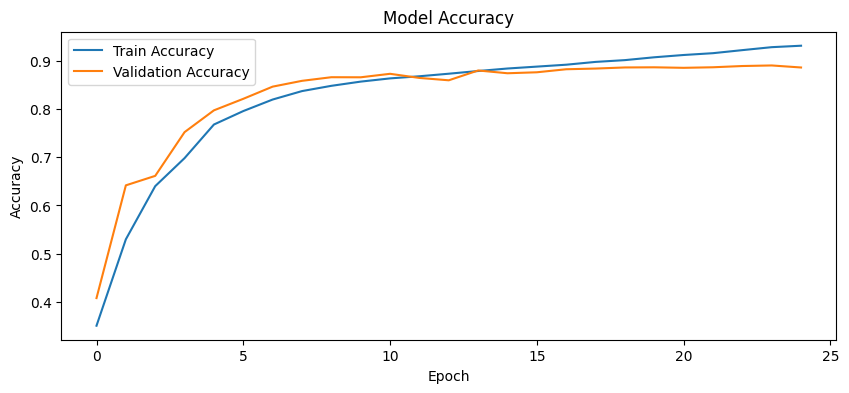

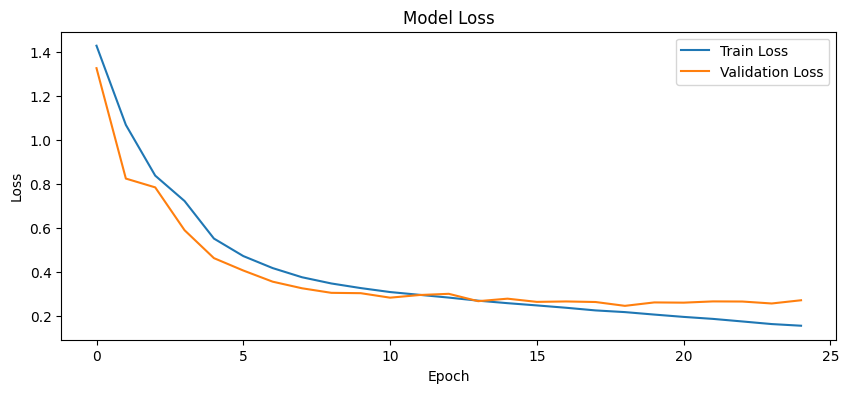

820/820 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step


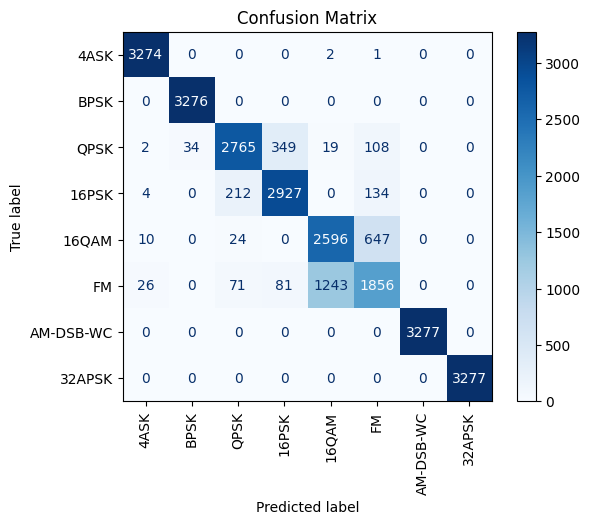

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict on test data
model_predictions = model.predict([X_test_i, X_test_q])

# Convert predictions and true labels to class indices
def get_class_indices(y_pred, y_true):
    y_pred_indices = np.argmax(y_pred, axis=1)
    y_true_indices = np.argmax(y_true.values, axis=1)
    return y_pred_indices, y_true_indices

y_pred_indices, y_true_indices = get_class_indices(model_predictions, y_test)

# Compute confusion matrix
cm = confusion_matrix(y_true_indices, y_pred_indices)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_modulation_classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()


5. Saving and Loading the Model

In [12]:
# Save model weights
model.save_weights('CNN_LSTMmodel.weights.h5')

# Load model weights into a new model instance
loaded_model = create_model()
loaded_model.load_weights('CNN_LSTMmodel.weights.h5')

# Evaluate the loaded model
loss, acc = loaded_model.evaluate([X_test_i, X_test_q], y_test, verbose=2)
print(f"Restored model, accuracy: {acc * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 64 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


820/820 - 8s - 10ms/step - accuracy: 0.8868 - loss: 0.2718
Restored model, accuracy: 88.68%
